## 3. Image Classification

### 3.1 Coding Questions

In [1]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load Ford/VW images and store them in training/test sets
img_names = os.listdir('./dataset/')
ford_test = []
ford_train = []
vw_test = []
vw_train = []
size = (128, 128)

# Resize and store training and test images
for file in img_names: 
    img = cv2.cvtColor(cv2.imread('./dataset/' + file), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)

    # Add image to train or test set
    if 'ford_train' in file:
        ford_train.append(img)
    elif 'ford_test' in file:
        ford_test.append(img)
    elif 'volks_train' in file:
        vw_train.append(img)
    elif 'volks_test' in file:
        vw_test.append(img)

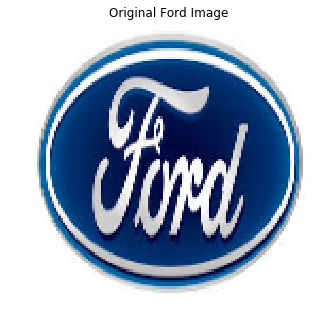

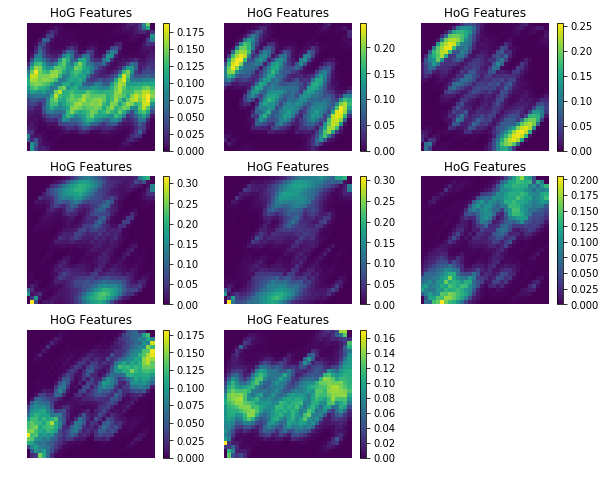

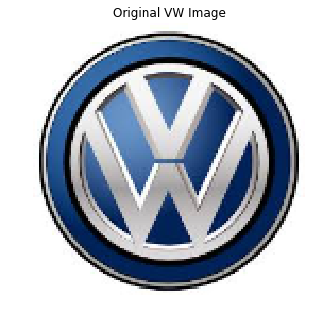

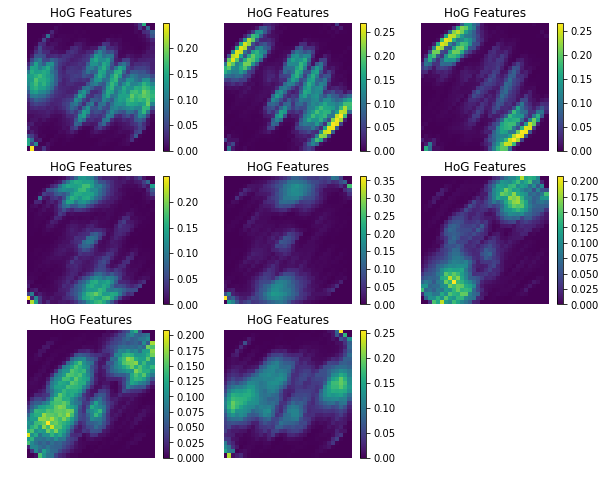

In [3]:
def compute_HoG(images, cell_size, block_size, nbins):
    """
    Compute HoG features of a list of images.
    :param images: List of images
    :param cell_size: Shape of pixels window per cell
    :param block_size: Shape of cells window per block
    """

    features = []
    for img in images:
        h, w, _ = img.shape
        c_h, c_w = cell_size
        b_h, b_w = block_size

        # Create HoG Object
        hog = cv2.HOGDescriptor(
            _winSize=(w // c_w * c_w, h // c_h * c_h),
            _blockSize=(b_w * b_w, b_h * b_h),
            _blockStride=(c_w, c_h),
            _cellSize=(c_w, c_h),
            _nbins=nbins)

        n_cells = (h // c_h, w // c_w)

        # Compute HoG features
        hog_feats = hog.compute(img) \
                       .reshape(n_cells[1] - b_w + 1, n_cells[0] - b_h + 1, b_h, b_w, nbins) \
                       .transpose((1, 0, 2, 3, 4))

        # Computation for BlockNorm
        gradients = np.zeros((n_cells[0], n_cells[1], nbins)).astype(np.float)
        cell_count = np.zeros((n_cells[0], n_cells[1], 1)).astype(np.float)

        for off_y in range(b_h):
            for off_x in range(b_w):
                gradients[off_y:n_cells[0] - b_h + off_y + 1,
                          off_x:n_cells[1] - b_w + off_x + 1] += hog_feats[:, :, off_y, off_x, :]
                cell_count[off_y:n_cells[0] - b_h + off_y + 1,
                           off_x:n_cells[1] - b_w + off_x + 1] += 1

        # Average gradients
        gradients /= cell_count
        features.append(gradients)

    return features

def plot_HoG(features):
    max_col = 3
    nbins = features.shape[-1]
    nb_row = math.ceil(nbins / max_col)
    nb_plot = nb_row * 100 + max_col * 10
    plt.figure(figsize = (10,8))
    for i in range(features.shape[-1]):
        plt.subplot(nb_plot + i + 1)
        plt.pcolor(features[:, :, i]), plt.colorbar()
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('HoG Features'), plt.gca().invert_yaxis(), plt.axis('off')
    plt.show()

ford_features = compute_HoG(ford_train, (4,4), (4,4), 8)
vw_features = compute_HoG(vw_train, (4,4), (4,4), 8)

# Display test HoG feature for Ford
img = ford_train[0]
gradients = ford_features[0]

plt.figure(figsize = (5,5))
plt.imshow(img, cmap='gray')
plt.title('Original Ford Image'), plt.axis('off')

plot_HoG(gradients)

# Display test HoG feature for VW
img = vw_train[0]
gradients = vw_features[0]

plt.figure(figsize = (5,5))
plt.imshow(img, cmap='gray')
plt.title('Original VW Image'), plt.axis('off')

plot_HoG(gradients)

In [4]:
# Create classifier
train_x = np.array(ford_features + vw_features)
train_x = train_x.reshape(train_x.shape[0], -1)

# Annotate images for training 
train_y = ['Ford' for _ in range(len(ford_train))] + ['VW' for _ in range(len(vw_train))]

# Train model using classifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

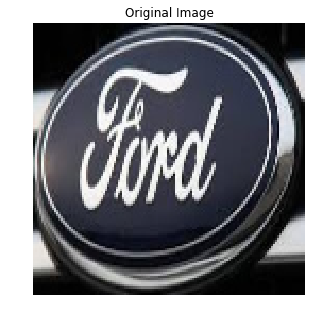

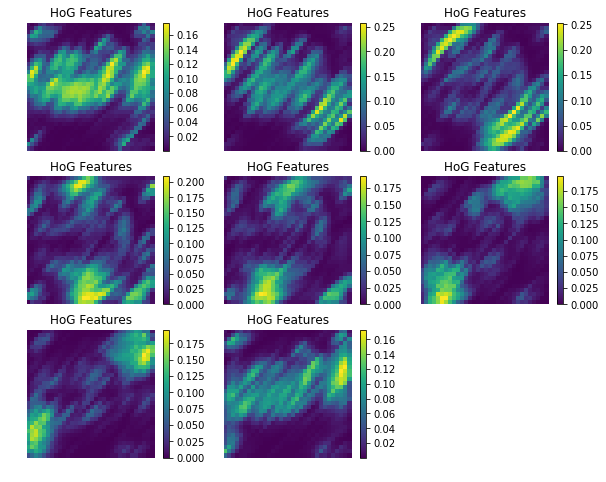

Car Model:  Ford


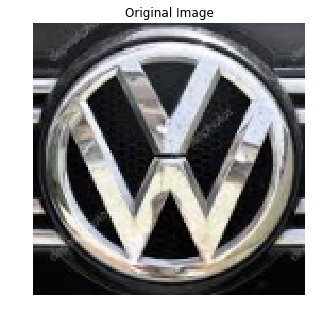

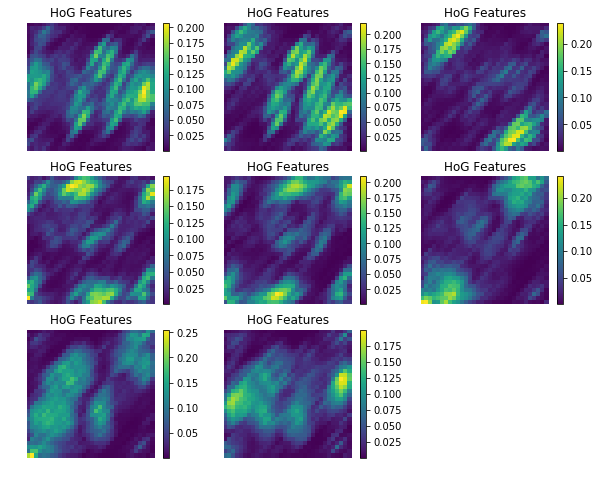

Car Model:  VW


In [5]:
test_img = ford_test + vw_test
test_features = np.array(compute_HoG(test_img, (4,4), (4,4), 8))
test_y = neigh.predict(test_features.reshape(len(test_img), -1))
for x, features, y in zip(test_img, test_features, test_y):
    plt.figure(figsize = (10,5))
    plt.imshow(x, cmap='gray')
    plt.title('Original Image'), plt.axis('off')

    plot_HoG(features)
    
    print('Car Model: ', y)

### 3.2 Reasoning Questions

1.
It won't work since HoG computation relies on the orientation of the image, although it is possible to regain the original orientation of the image by finding the images keypoints and descriptors and warping it back.

2.
Since there's only 2 orientations (x and y), we would only require 2 different directions of the gradient in x and y.